### Unpack ETL files

In [1]:
import os
from pathlib import Path

from openai.types.beta.threads import image_file

project_root = Path().resolve()
etl_dir = project_root / "data" / "ETL8G"
unpack_script = project_root / "data" / "unpack_etlcdb" / "unpack_etlcdb" / "unpack.py"

files = os.listdir(etl_dir)

for file in files:
    if file != "ETL8INFO":
        input_file = etl_dir / file
        cmd = f'python {unpack_script} {input_file}'
        print("Running:", cmd)
        # os.system(cmd)



Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_01
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_01_unpack
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_02
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_02_unpack
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_03
Running: python C:\Users\alicj\PycharmProjects\KanjiRecogniti

### Saving labels to list

In [2]:
import pandas as pd

path_to_labels = Path().resolve()/ "data" / "ETL8G"/ "ETL8G_01_unpack"/"meta.csv"

labels_df = pd.read_csv(path_to_labels)

labels = labels_df["char"]
labels = labels.tolist()


In [3]:
all_labels = labels.copy()
labels_copy = all_labels.copy()

for i in range(31):
    labels_copy_2 = labels_copy.copy()
    all_labels.extend(labels_copy_2)

all_labels.extend(labels_copy[:956])

In [4]:
# from sklearn.preprocessing import LabelEncoder
#
# le = LabelEncoder()
# labels_int = le.fit_transform(labels)
#
# print(labels_int[:10])        # now numbers like [0, 1, 0, 2, ...]
# print(le.classes_[:10])       # the mapping back to original labels


In [5]:
# go through each folder
path_label_list = []
etl_dir = Path().resolve() / "data" / "ETL8G"
for folder in os.listdir(etl_dir):
    if "unpack" in folder:
        folder_path = os.path.join(etl_dir, folder)

        # go through each png in folder
        for fname in os.listdir(folder_path):
            if fname.endswith(".png"):
                fpath = os.path.join(folder_path, fname)
                # take filename without extension
                idx = int(os.path.splitext(fname)[0])
                # compute label
                label = idx % 956
                path_label_list.append((fpath, label))

print(path_label_list[956])


('C:\\Users\\alicj\\PycharmProjects\\KanjiRecognitionModel\\data\\ETL8G\\ETL8G_01_unpack\\00956.png', 0)


In [6]:
print(len(path_label_list))

153916


In [7]:
print(labels[1])
print(path_label_list[1912])

愛
('C:\\Users\\alicj\\PycharmProjects\\KanjiRecognitionModel\\data\\ETL8G\\ETL8G_01_unpack\\01912.png', 0)


### Saving images

In [8]:
image_paths = []
img_dir_path = Path().resolve()/ "data" / "ETL8G"

files = os.listdir(img_dir_path)
for file in files:
    if "unpack" in file:
        unpack_dir = img_dir_path / file
        img_files = os.listdir(unpack_dir)
        for img_file in img_files:
            if img_file != 'meta.csv':
                img_path = unpack_dir / img_file
                image_paths.append(img_path)

# in the last dir there are only 955 images



In [10]:
print(len(labels))

4780


### Dataset class

In [11]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import torchvision.transforms as T

class ImageDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # item = self.data[idx]
        # path = item[0]
        # img = Image.open(path)
        # img=img.convert("L")
        # img = T.ToTensor()(img)
        # label =item[1]
        # # img.show()
        # return img, torch.tensor(label, dtype=torch.long)
        path, label = self.data[idx]
        img = Image.open(path).convert("L")
        if self.transform:
            img = self.transform(img)
        else:
            img = T.ToTensor()(img)
        return img, torch.tensor(label, dtype=torch.long)



In [12]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
])

a = ImageDataset(path_label_list, transform)
img, lab = a[0]
# print(img.size)
print(lab)
print(type(img), img.shape, lab)

tensor(0)
<class 'torch.Tensor'> torch.Size([1, 64, 64]) tensor(0)


### Splitting the data into train, val, test sets

In [122]:
from sklearn.model_selection import train_test_split

# first split train vs temp (val+test)
train_data, temp_data = train_test_split(path_label_list[:50000], test_size=0.3, random_state=42, stratify=[d[1] for d in path_label_list[:50000]]) # used stratify to preserve the same class proportions

# then split temp into val and test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=[d[1] for d in temp_data])


In [123]:
train_dataset = ImageDataset(train_data, transform)
val_dataset   = ImageDataset(val_data, transform)
test_dataset  = ImageDataset(test_data, transform)


### Data Loader

In [124]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, num_workers=0)


TEST

In [125]:
imgs, labels = next(iter(train_loader))
print(imgs.shape)    # [32, 1, 64, 64]
print(labels.shape)  # [32]


torch.Size([32, 1, 64, 64])
torch.Size([32])


In [126]:
import torch
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T

# 1) Build a proper Dataset from your (path, label) list
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),                 # [0,1], shape [1,64,64] (your dataset .convert("L") already makes grayscale)
    T.Normalize([0.5], [0.5]),
])
dataset = ImageDataset(path_label_list, transform=transform)

# # 2) Take a random subset of 1000 items
# subset_size = min(20000, len(dataset))    # just in case you have < 1000
# indices = torch.randperm(len(dataset))[:subset_size]
# small_dataset = Subset(dataset, indices)

# 3) DataLoader from the subset (num_workers=0 is safest in notebooks)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=64, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=64, num_workers=0)

# 4) Sanity check: can we get one batch?
imgs, labels = next(iter(train_loader))
print(imgs.shape, labels.shape)  # expect: torch.Size([64, 1, 64, 64]) and torch.Size([64])


torch.Size([64, 1, 64, 64]) torch.Size([64])


### Check data leakage

In [127]:
train_paths = [img[0] for img, _ in train_loader.dataset] if isinstance(train_loader.dataset[0], tuple) else [train_loader.dataset.data[i][0] for i in range(len(train_loader.dataset))]
val_paths   = [img[0] for img, _ in val_loader.dataset]   if isinstance(val_loader.dataset[0], tuple)   else [val_loader.dataset.data[i][0] for i in range(len(val_loader.dataset))]

# Turn them into sets
train_set = set(train_paths)
val_set = set(val_paths)

# Check for overlap
overlap = train_set.intersection(val_set)
print(f"Overlap count: {len(overlap)}")

if len(overlap) > 0:
    print("Example overlap paths:", list(overlap)[:5])
else:
    print("✅ No data leakage detected between train and validation sets!")


Overlap count: 0
✅ No data leakage detected between train and validation sets!


In [128]:
import time
t0 = time.time()
images, labels = next(iter(train_loader))
print(f"Loaded one batch in {time.time() - t0:.2f} seconds")
print("Batch shape:", images.shape, "Labels:", labels.shape)


Loaded one batch in 0.07 seconds
Batch shape: torch.Size([64, 1, 64, 64]) Labels: torch.Size([64])


In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # input: 1x64x64 → output: 8x64x64
        self.pool = nn.MaxPool2d(2, 2)                         # → 8x32x32
        self.dropout = nn.Dropout(0.3)
        self.fc   = nn.Linear(8 * 32 * 32, num_classes)        # flatten → fully connected

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))  # conv → relu → pool
        x = x.view(x.size(0), -1)            # flatten
        x = self.fc(x)                       # final layer
        return x


In [130]:
@torch.no_grad()
def evaluate(model, loader):
    """Compute accuracy of a model on a given DataLoader."""
    model.eval()                          # evaluation mode (no dropout, batchnorm updates)
    correct, total = 0, 0
    for images, labels in loader:
        outputs = model(images)            # forward pass
        preds = outputs.argmax(1)          # highest logit = predicted class
        correct += (preds == labels).sum().item()
        total += labels.numel()
    acc = correct / total
    return acc


In [131]:
@torch.no_grad()              # we don’t need gradients for validation
def calc_val_loss(model, val_loader, criterion):
    model.eval()              # turn off dropout/batchnorm updates
    total_loss = 0.0
    total_samples = 0

    for images, labels in val_loader:
        outputs = model(images)            # forward pass only
        loss = criterion(outputs, labels)  # compute loss for the batch
        total_loss += loss.item() * images.size(0)
        total_samples += labels.size(0)

    avg_val_loss = total_loss / total_samples
    return avg_val_loss


In [132]:
# === setup ===
device = torch.device("cpu")   # change to "cuda" if you fix your GPU
num_classes = 956              # for example

model = TinyCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# assume you already have a DataLoader
# for example: train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

train_losses = []
val_losses = []


# === training loop ===
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # move to device
        images, labels = images.to(device), labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    val_acc = evaluate(model, val_loader)
    val_loss = calc_val_loss(model, val_loader, criterion)
    # ---- store both ----
    train_losses.append(avg_loss)
    val_losses.append(val_loss)

    # print(f"Epoch {epoch+1}: Train loss = {avg_loss:.4f}, Val acc = {val_acc*100:.2f}%")
    print(f"Epoch {epoch+1}: train_loss={avg_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

    # print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")

print("✅ Training complete!")

Epoch 1: train_loss=6.7145, val_loss=6.3525, val_acc=7.01%
Epoch 2: train_loss=6.0440, val_loss=5.8573, val_acc=25.56%
Epoch 3: train_loss=5.4796, val_loss=5.3722, val_acc=31.27%
Epoch 4: train_loss=4.8990, val_loss=4.8748, val_acc=36.29%
Epoch 5: train_loss=4.1566, val_loss=4.0479, val_acc=44.43%
Epoch 6: train_loss=3.2702, val_loss=3.5337, val_acc=49.24%
Epoch 7: train_loss=2.7147, val_loss=3.1553, val_acc=52.49%
Epoch 8: train_loss=2.2969, val_loss=2.8706, val_acc=53.99%
Epoch 9: train_loss=1.9696, val_loss=2.6587, val_acc=56.25%
Epoch 10: train_loss=1.7115, val_loss=2.4857, val_acc=57.59%
✅ Training complete!


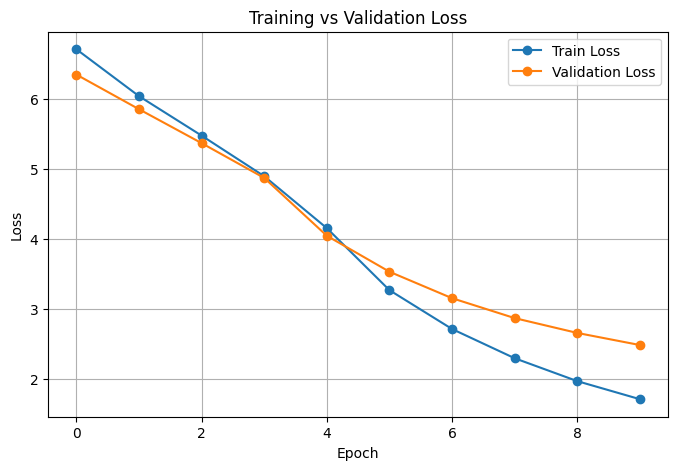

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Test CNN

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 1 input channel (grayscale), 8 filters
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)   # reduces size by half
        # Flattened size after pool (assuming 64x64 input): 8 * 32 * 32
        self.fc1 = nn.Linear(32256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # conv → relu → pool
        x = x.view(x.size(0), -1)             # flatten
        x = self.fc1(x)                       # fully connected
        return x


In [20]:
# Example: suppose you have 100 kanji classes
model = SimpleCNN(num_classes=956)

# One fake batch: 32 grayscale images, 64x64 each
x = torch.randn(32, 1, 64, 64)
out = model(x)

print(out.shape)  # torch.Size([32, 100]) → 32 predictions, 100 classes


NameError: name 'SimpleCNN' is not defined

In [138]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):  # 3 training epochs
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()         # reset gradients
        outputs = model(images)       # forward pass
        loss = criterion(outputs, labels)
        loss.backward()               # backward pass
        optimizer.step()              # update weights
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


KeyboardInterrupt: 